In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models
import datetime as dt
from sklearn import metrics

In [2]:
def SIR(data,pop,gamma,rep_num,only_new_cases = False):
    
    beta = gamma * rep_num    
    new_cases = beta * data['susceptible'] * data['cases_active'] / pop
    
    if only_new_cases:
        return new_cases
    else:
        new_recovered = gamma * data['cases_active']
        
        susceptible = data['susceptible'] - new_cases
        cases = data['cases_active'] + new_cases - new_recovered
        recovered = data['recovered'] + new_recovered
        
        return susceptible,new_cases,rep_num,cases,new_recovered,recovered
    
def get_data(population,days_to_recovery):
    gamma = 1 / days_to_recovery
    
    df = pd.read_csv('https://raw.githubusercontent.com/MoH-Malaysia/covid19-public/main/epidemic/cases_malaysia.csv',
                          parse_dates = ['date'],index_col = ['date']).loc[:,['cases_new','cases_active']]
    
    df['recovered_new'] = (df['cases_new'] + df['cases_active'].shift(1) - df['cases_active']).fillna(0)
    df['recovered'] = df['recovered_new'].cumsum()
    growth_rate = ((df['cases_active'] - df['cases_active'].shift(1)) / df['cases_active'].shift(1)).fillna(0)
    df.insert(1,'reproduction_number',np.maximum(0,1 + (growth_rate / gamma)))
    df.insert(0,'susceptible',population - df['recovered'])
    df['cases_new_tomorrow'] = [int(SIR(df.loc[df.index[idx]],
                                        population,gamma,
                                        df.loc[df.index[idx],'reproduction_number'],
                                        only_new_cases = True)) for idx in range(len(df.index))]
    
    #Assume tomorrow's R value is the same as today
    df['r_error'] = df['reproduction_number'].shift(1) - df['reproduction_number']
    df['case_error'] = df['cases_new_tomorrow'].shift(1) - df['cases_new']
    
    return df.loc[df.index < '2022-11-01']

def calc_rmse(data):
    return np.sqrt((data ** 2).mean())

def set_sequence(size,data):
    x = []
    y = []
    
    for count in range(len(data) - size):
        window = [[s] for s in data[count : count + size]]
        label = data[count + size]
        
        x.append(window)
        y.append(label)
        
    return np.array(x),np.array(y)

def plot_test_r(df,x,model,length):
    TRAIN_SPLIT = int(0.8 * len(df.index))
    pred = model.predict(x)
    y = df.loc[df.index >= df.index[TRAIN_SPLIT],'reproduction_number']
    score = np.sqrt(metrics.mean_squared_error(pred,y))
    print("Score (RMSE): {}".format(score))
    
    sub_df = df.loc[df.index >= df.index[TRAIN_SPLIT],['reproduction_number']]
    sub_df['reproduction_number'] = pred

    plt.figure()
    plt.plot(y)
    plt.plot(sub_df['reproduction_number'])
    plt.title(f'{length}-Sequence Effective Reproduction Number Prediction Test (RMSE: {np.round(score,4)})')
    plt.ylabel('Effective Reproduction Number')
    plt.xlabel('Date')
    plt.legend(['Actual','Prediction'])
    plt.show()
    
    return score

def plot_test_cases(df,x,model,length):
    TRAIN_SPLIT = int(0.8 * len(df.index))
    pred = model.predict(x)

    sub_df = df.loc[df.index >= df.index[TRAIN_SPLIT],['reproduction_number']]

    sub_df.loc[sub_df.index >= df.index[TRAIN_SPLIT],'reproduction_number'] = [pred[i][0] for i in range(len(pred))]
    sub_df['prediction'] = 0
    sub_df['actual'] =  df.loc[df.index >= df.index[TRAIN_SPLIT],'cases_new']
    sub_df['error'] = 0

    for idx in sub_df.index:
        rep_num = sub_df.loc[idx,'reproduction_number']
        sub_df.loc[idx,'prediction'] = SIR(df.loc[idx - dt.timedelta(1)],population,1/days_recovery,rep_num)[1]
        sub_df.loc[idx,'error'] = sub_df.loc[idx,'prediction'] - sub_df.loc[idx,'actual']

    error = np.sqrt((sub_df['error'] ** 2).mean())

    plt.figure()
    plt.plot(df.loc[df.index >= df.index[TRAIN_SPLIT],'cases_new'])
    plt.plot(sub_df['prediction'])
    plt.ylabel('Daily Cases')
    plt.xlabel('Date')
    plt.title(f'{length}-Sequence Daily Cases Prediction Test (RMSE: {np.round(error,4)})')
    plt.legend(['Actual','Prediction'])
    plt.show()
    
    return error

In [3]:
population = 33942526
days_recovery = 13
df = get_data(population,days_recovery)

df.head()

susceptible  cases_new  reproduction_number  cases_active  \
date                                                                    
2020-01-25   33942526.0          4                 1.00             4   
2020-01-26   33942526.0          0                 1.00             4   
2020-01-27   33942526.0          0                 1.00             4   
2020-01-28   33942526.0          0                 1.00             4   
2020-01-29   33942526.0          3                10.75             7   

            recovered_new  recovered  cases_new_tomorrow  r_error  case_error  
date                                                                           
2020-01-25            0.0        0.0                   0      NaN         NaN  
2020-01-26            0.0        0.0                   0     0.00         0.0  
2020-01-27            0.0        0.0                   0     0.00         0.0  
2020-01-28            0.0        0.0                   0     0.00         0.0  
2020-01-29            0.0        0.0                   5    -9.75        -3.0

In [4]:
model = {}

for i in range(1,21):
    model[i] = models.load_model(f'TRANSFORMER-{str(days_recovery).zfill(2)}-SEQLENGTH-{str(i).zfill(2)}.h5')

7/7 [==============================] - 2s 6ms/step
Score (RMSE): 0.36507537891238884


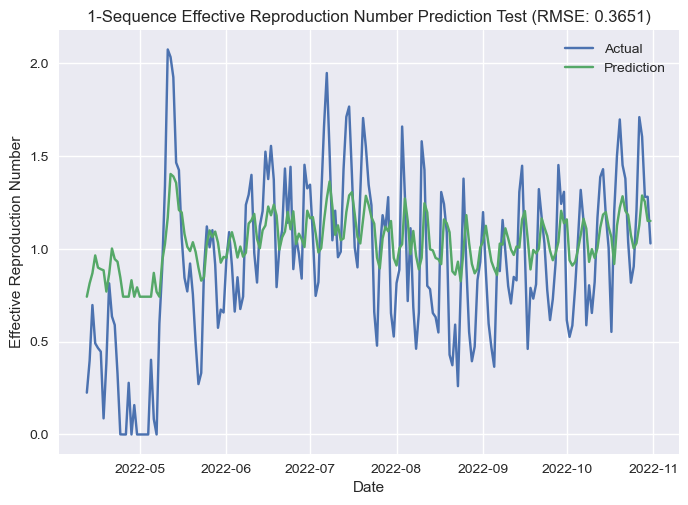

7/7 [==============================] - 0s 6ms/step


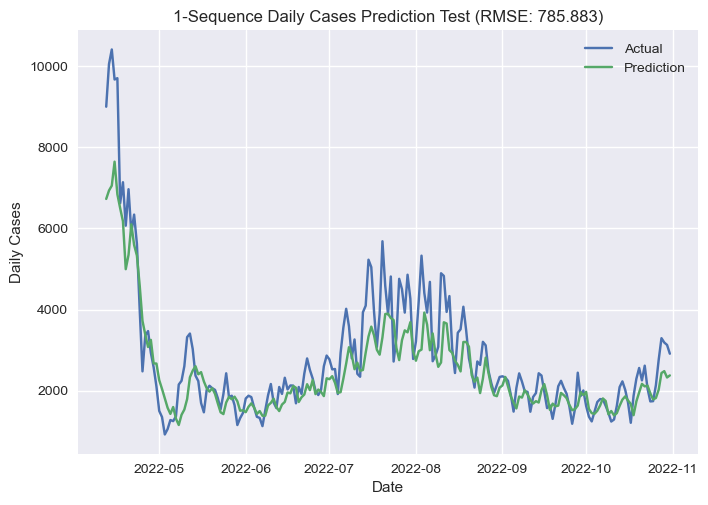

7/7 [==============================] - 1s 8ms/step
Score (RMSE): 0.35263204537981474


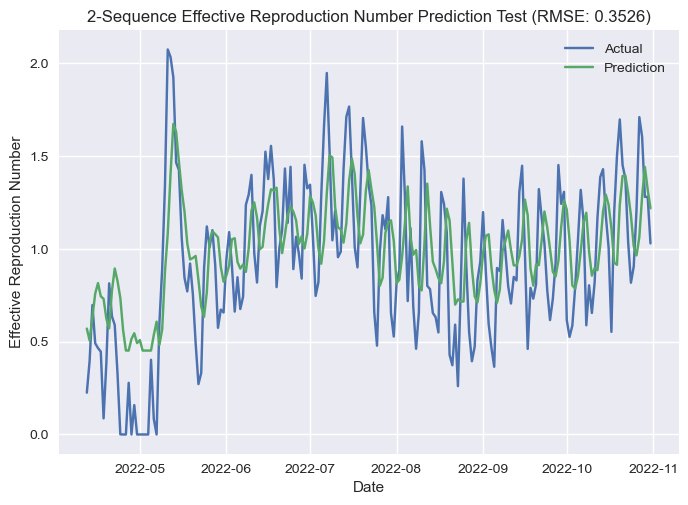

7/7 [==============================] - 0s 8ms/step


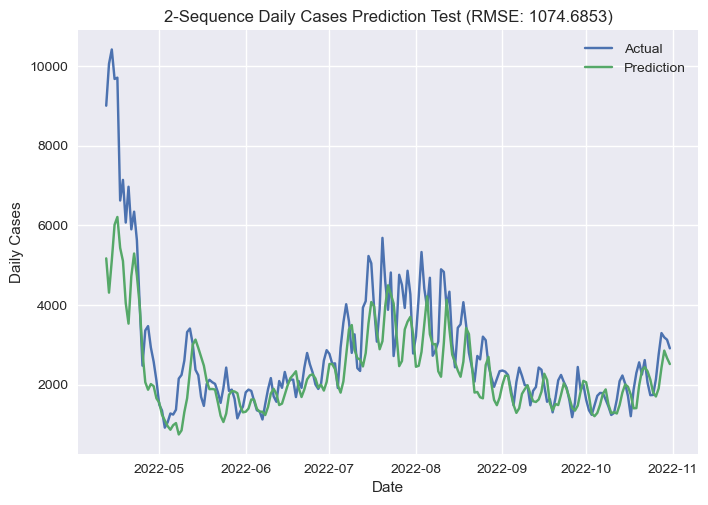

7/7 [==============================] - 1s 9ms/step
Score (RMSE): 0.567339963630445


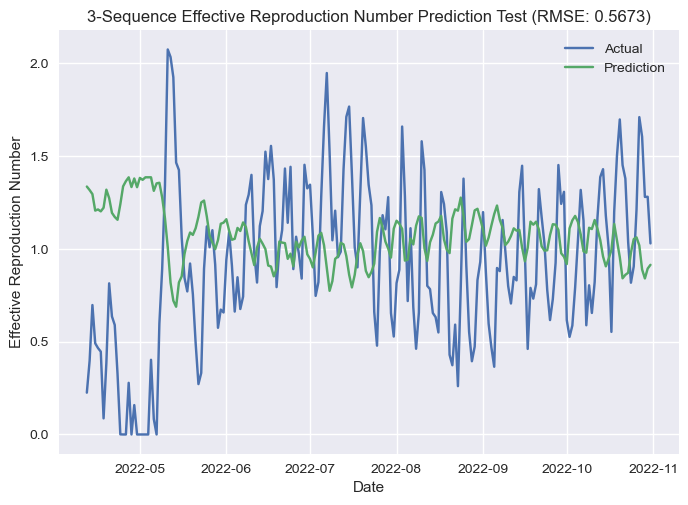

7/7 [==============================] - 0s 8ms/step


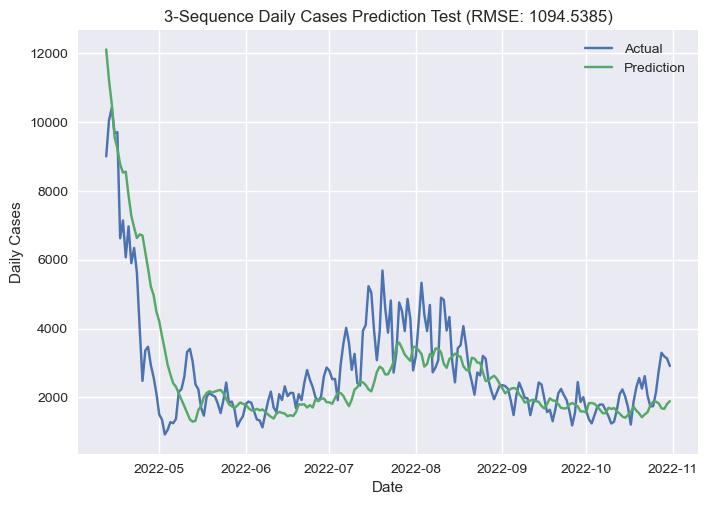

7/7 [==============================] - 1s 10ms/step
Score (RMSE): 0.5448358924245721


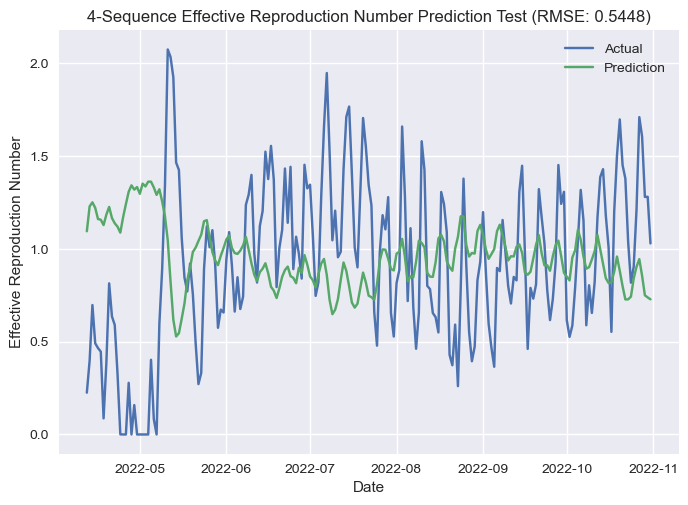

7/7 [==============================] - 0s 9ms/step


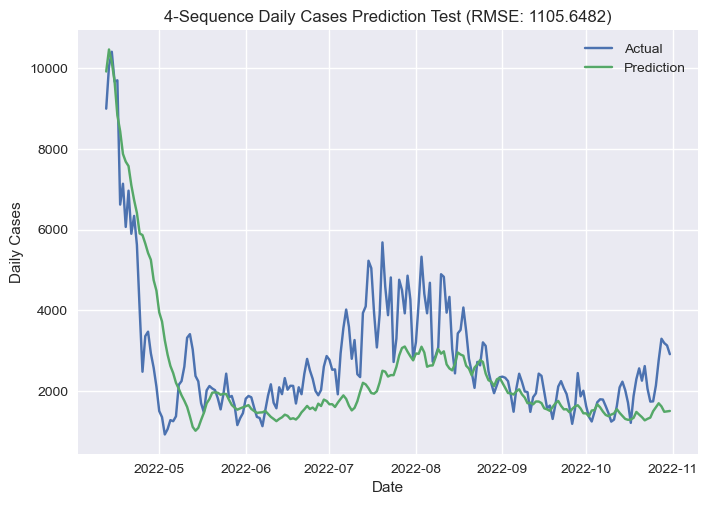

7/7 [==============================] - 1s 10ms/step
Score (RMSE): 0.5744144580421308


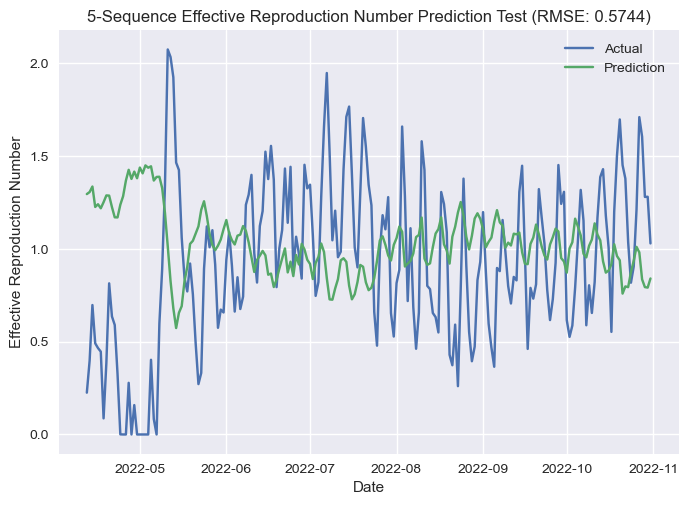

7/7 [==============================] - 0s 9ms/step


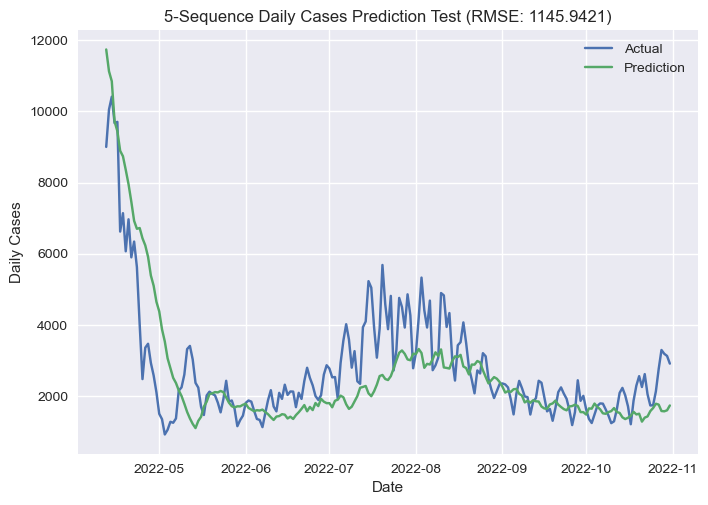

7/7 [==============================] - 1s 11ms/step
Score (RMSE): 0.3568040702715345


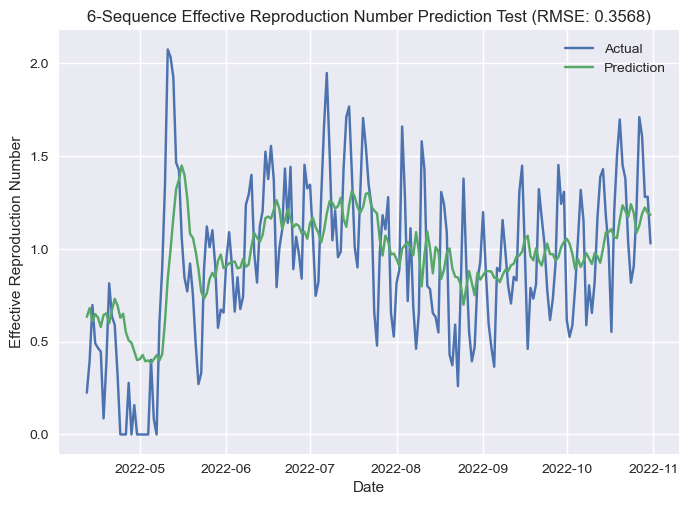

7/7 [==============================] - 0s 14ms/step


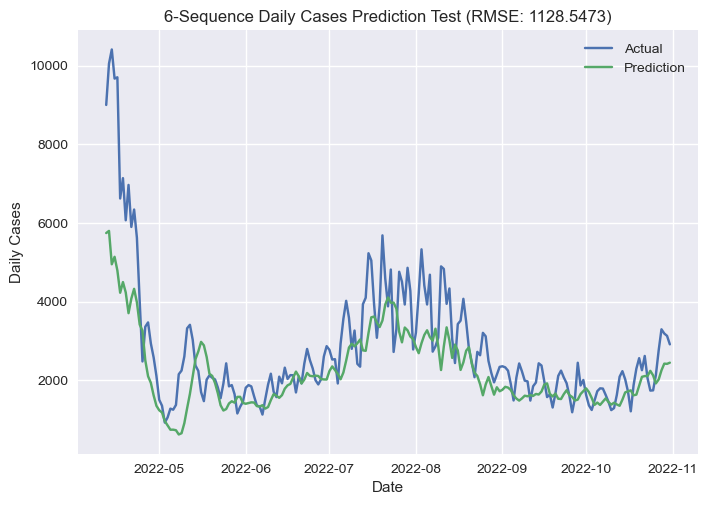

7/7 [==============================] - 1s 16ms/step
Score (RMSE): 0.3299304789574325


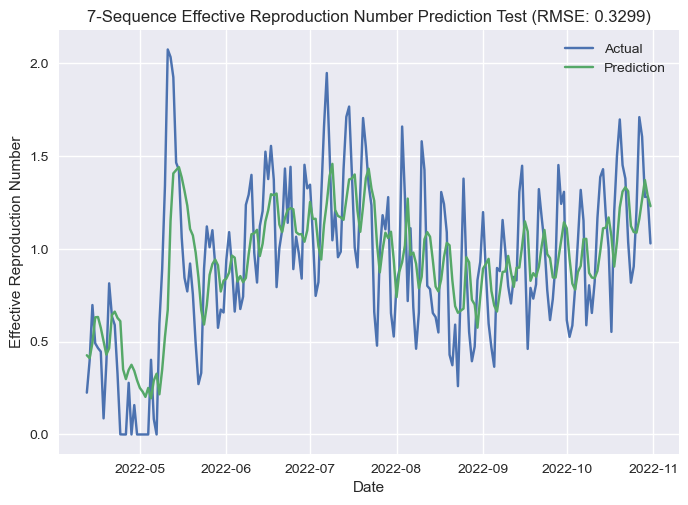

7/7 [==============================] - 0s 12ms/step


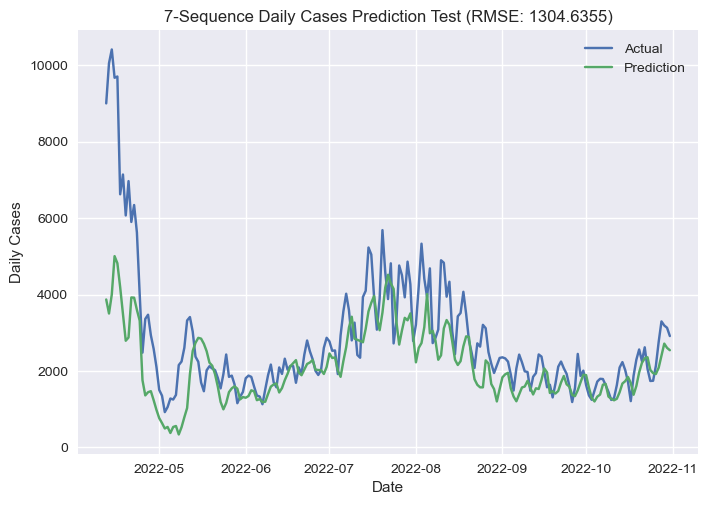

7/7 [==============================] - 1s 11ms/step
Score (RMSE): 0.37091180437127613


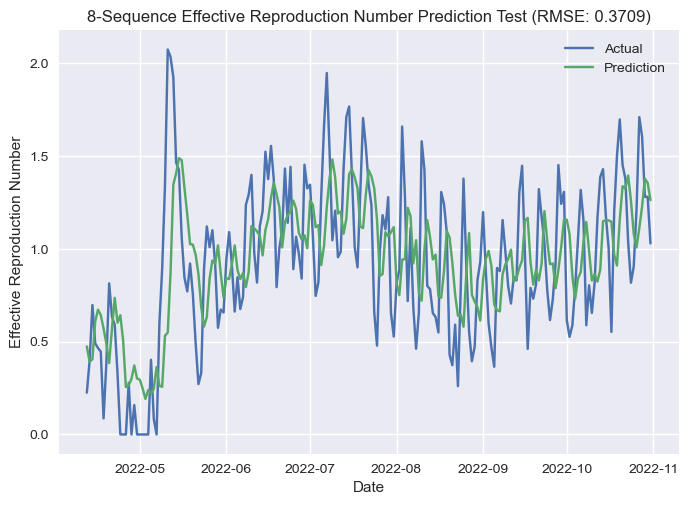

7/7 [==============================] - 0s 12ms/step


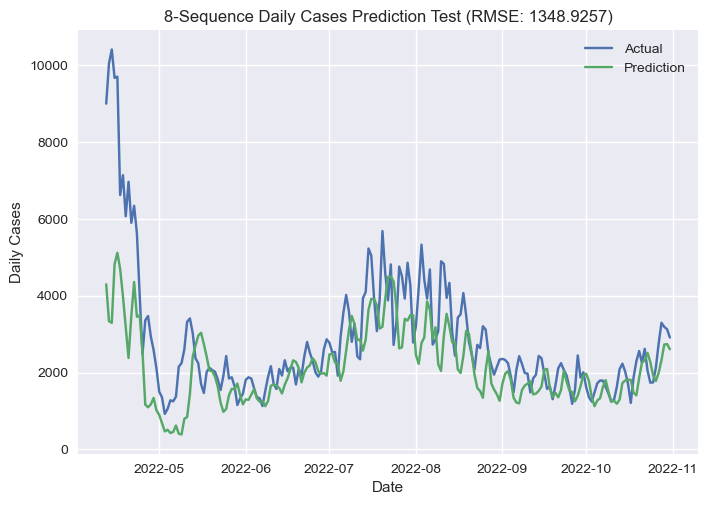

7/7 [==============================] - 1s 13ms/step
Score (RMSE): 0.41556719232564765


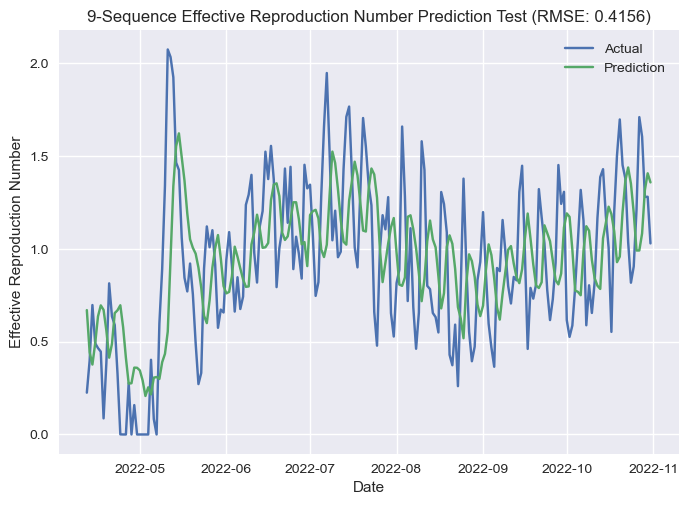

7/7 [==============================] - 0s 13ms/step


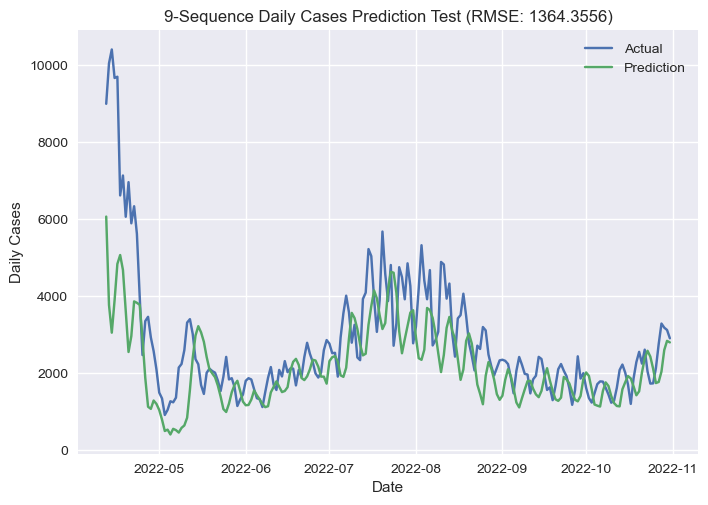

7/7 [==============================] - 1s 14ms/step
Score (RMSE): 0.43299517346314204


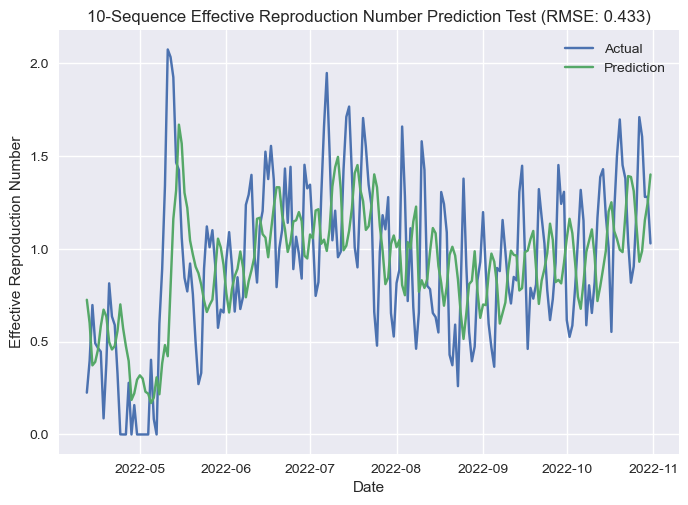

7/7 [==============================] - 0s 13ms/step


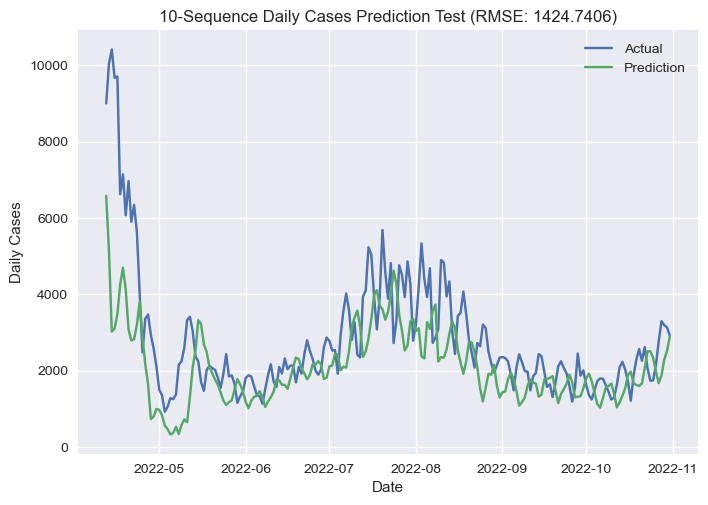

7/7 [==============================] - 1s 14ms/step
Score (RMSE): 0.38314854250852637


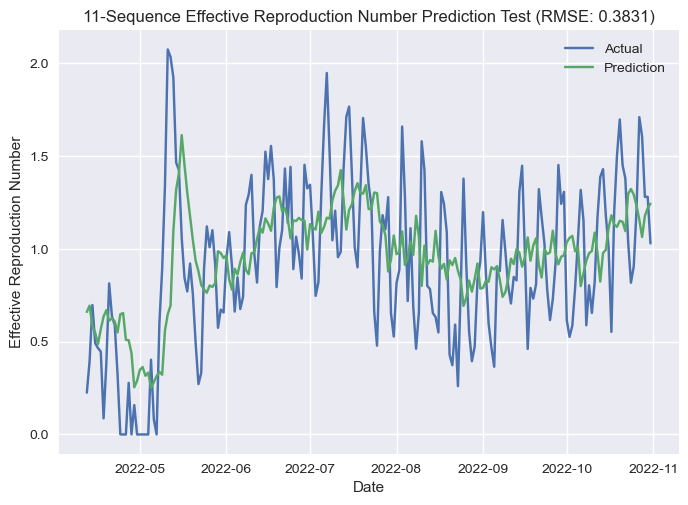

7/7 [==============================] - 0s 13ms/step


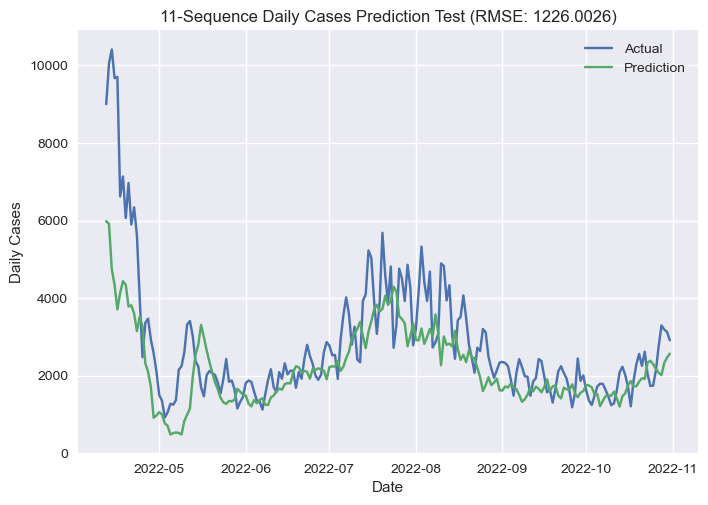

7/7 [==============================] - 1s 14ms/step
Score (RMSE): 0.3810208097814686


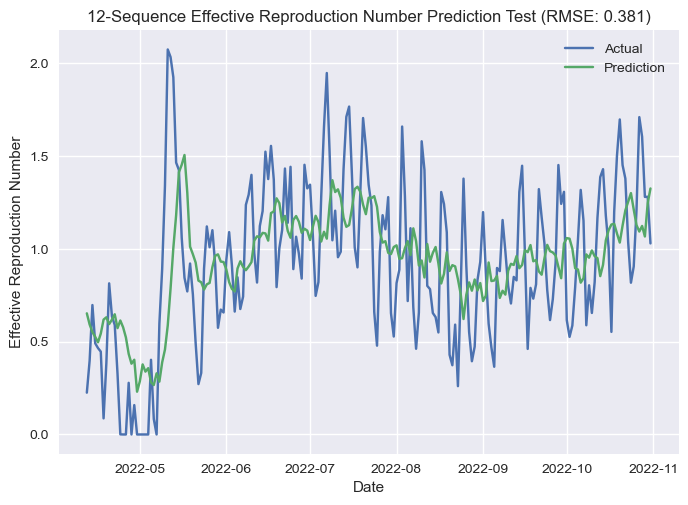

7/7 [==============================] - 0s 13ms/step


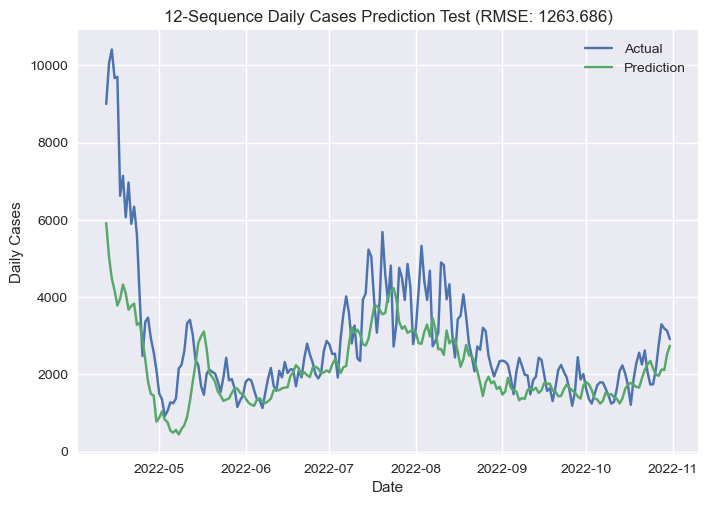

7/7 [==============================] - 1s 16ms/step
Score (RMSE): 0.34918590443359115


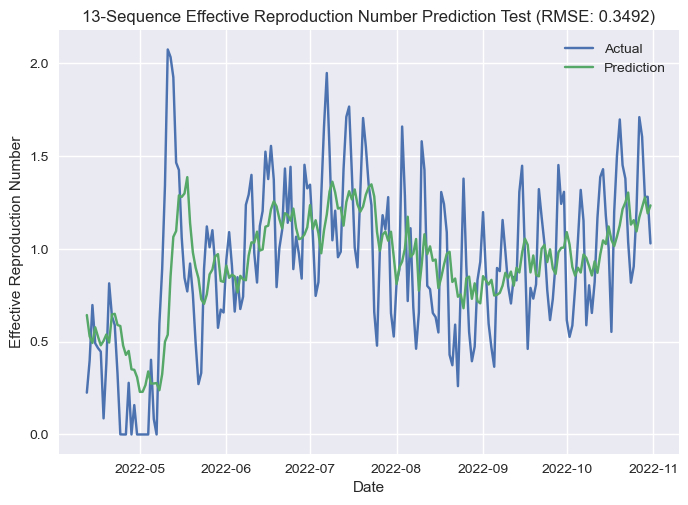

7/7 [==============================] - 0s 16ms/step


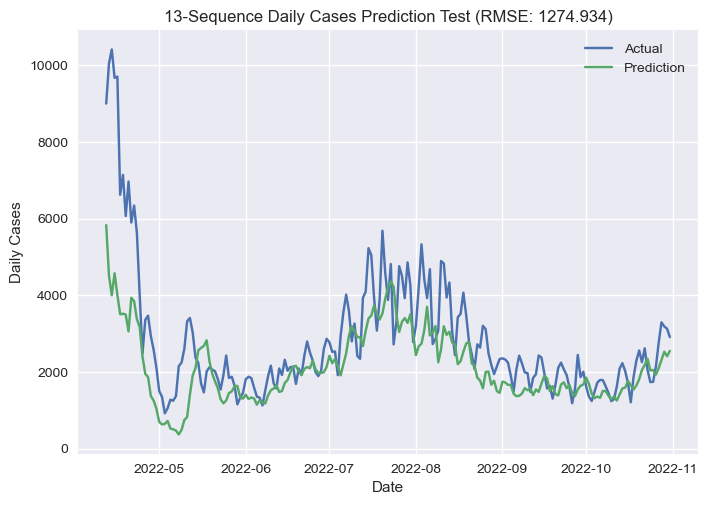

7/7 [==============================] - 1s 16ms/step
Score (RMSE): 0.36804575613995716


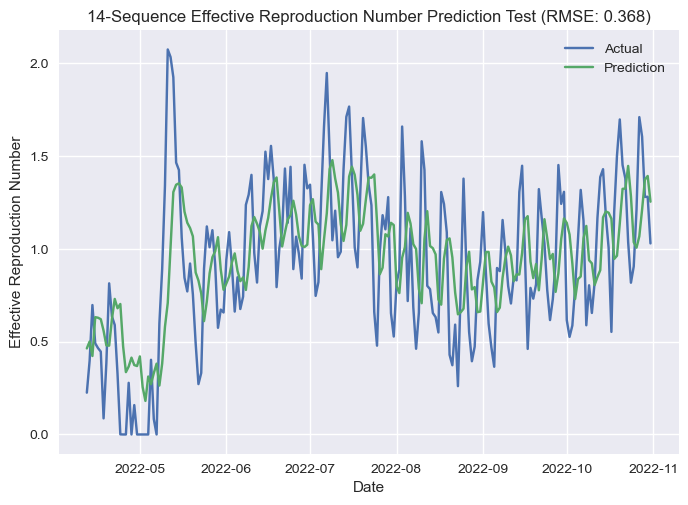

7/7 [==============================] - 0s 22ms/step


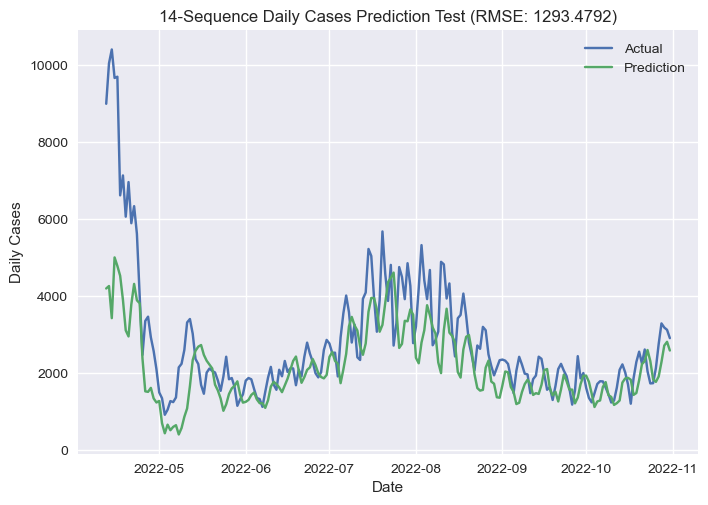

7/7 [==============================] - 1s 18ms/step
Score (RMSE): 0.4139233384741314


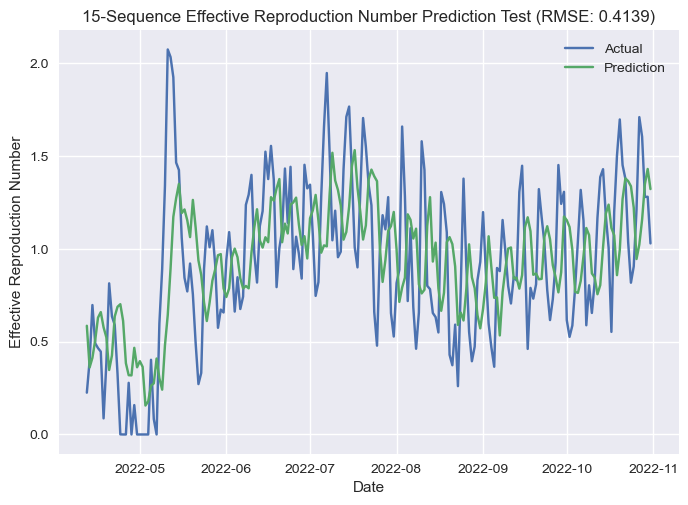

7/7 [==============================] - 0s 19ms/step


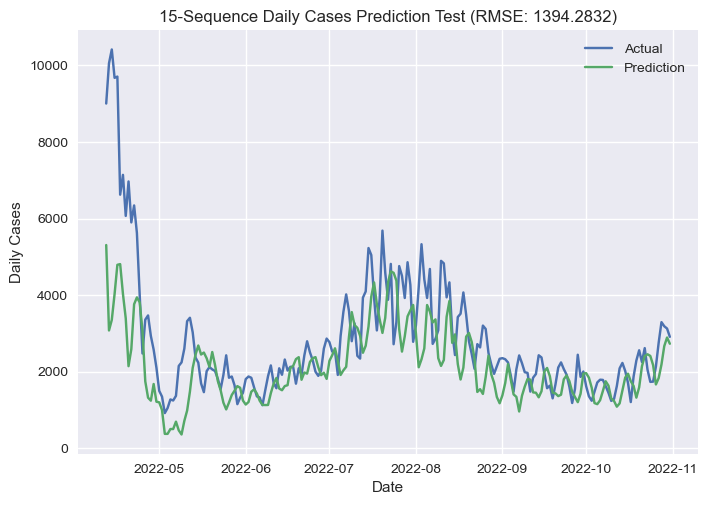

7/7 [==============================] - 1s 25ms/step
Score (RMSE): 0.432557735245984


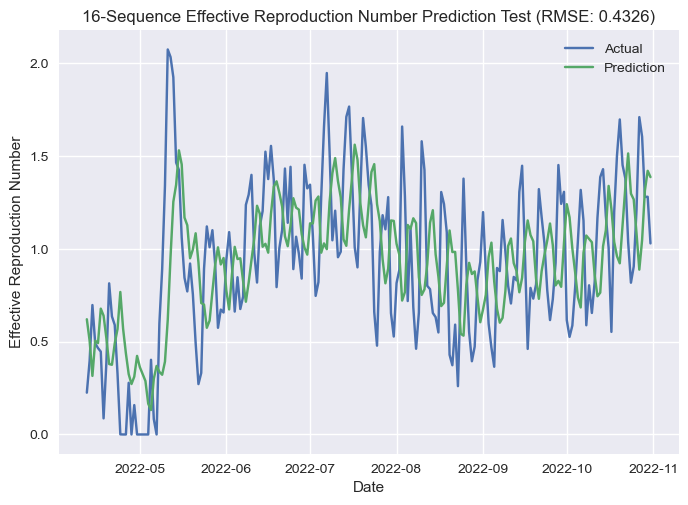

7/7 [==============================] - 0s 21ms/step


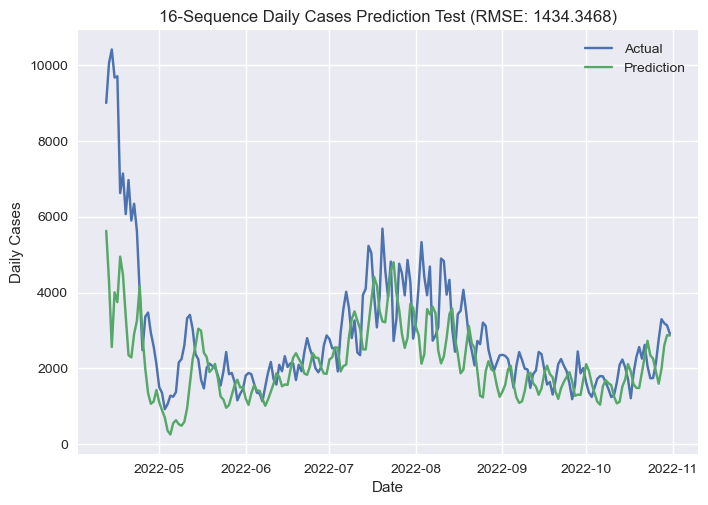

7/7 [==============================] - 1s 20ms/step
Score (RMSE): 0.4004349762276518


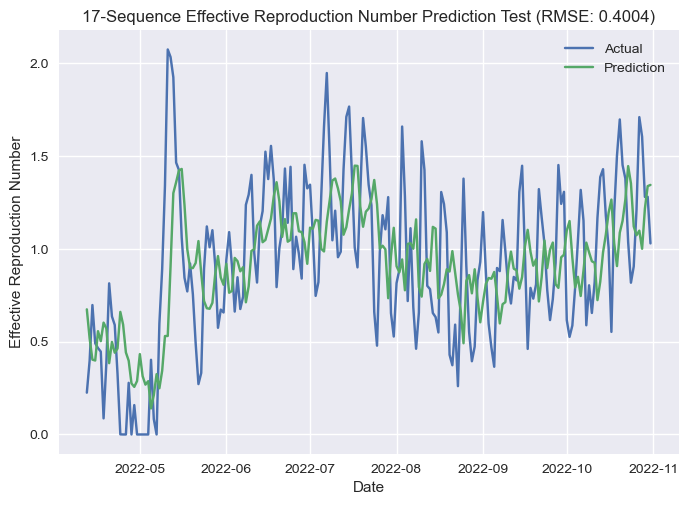

7/7 [==============================] - 0s 20ms/step


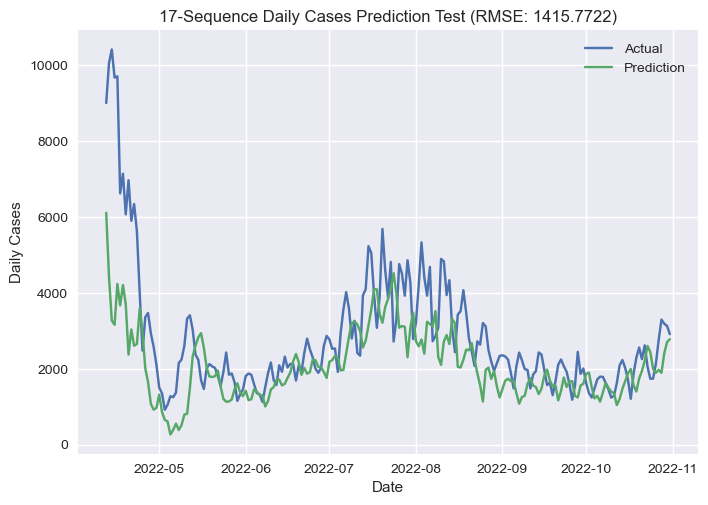

7/7 [==============================] - 1s 21ms/step
Score (RMSE): 0.36778452815303103


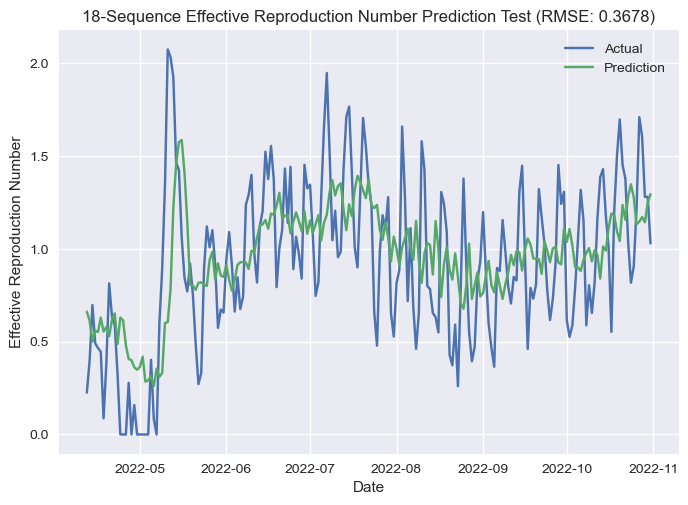

7/7 [==============================] - 0s 19ms/step


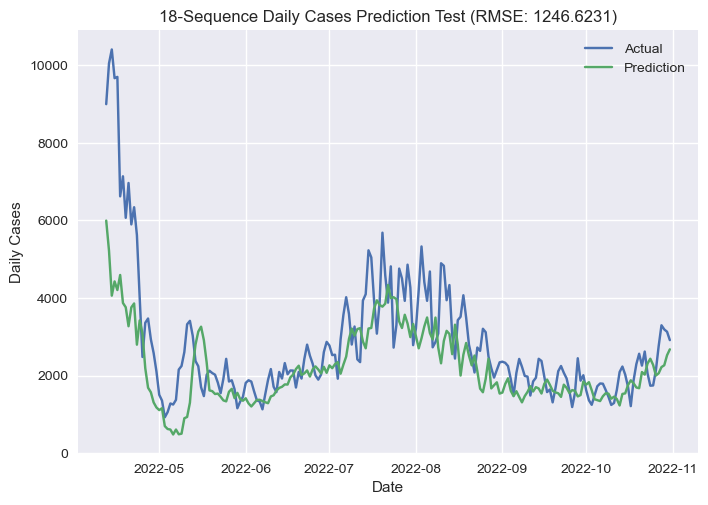

7/7 [==============================] - 1s 21ms/step
Score (RMSE): 0.3491387521122672


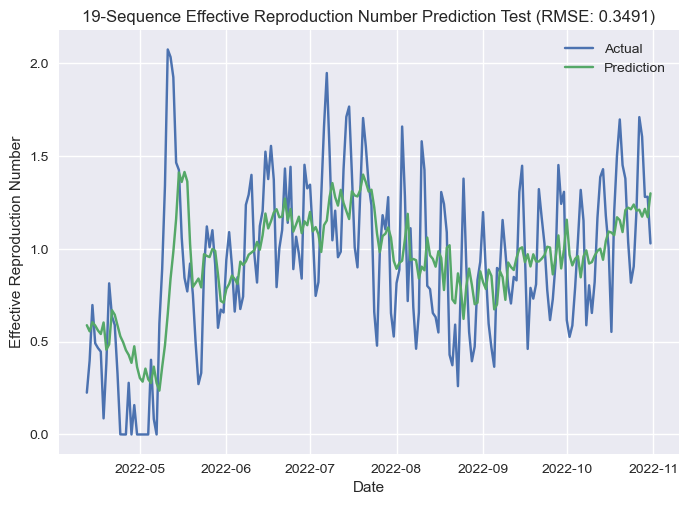

7/7 [==============================] - 0s 21ms/step


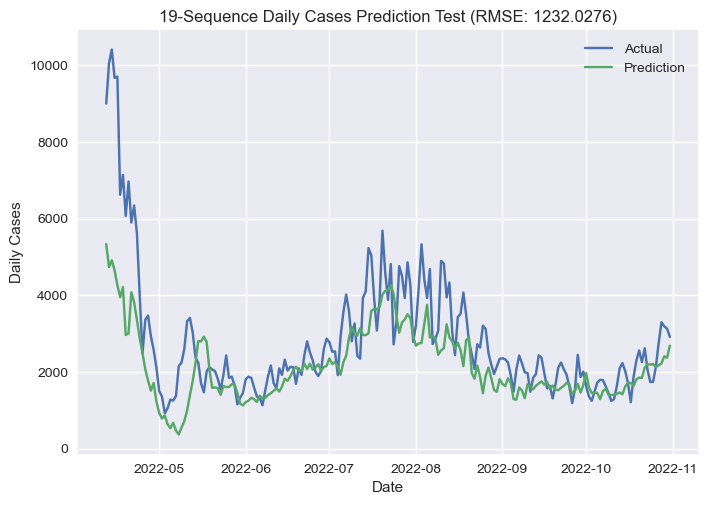

7/7 [==============================] - 1s 23ms/step
Score (RMSE): 0.33796472161824026


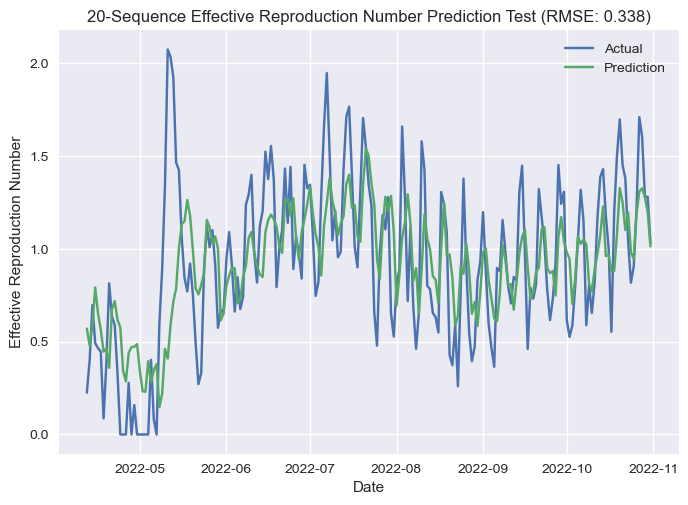

7/7 [==============================] - 0s 26ms/step


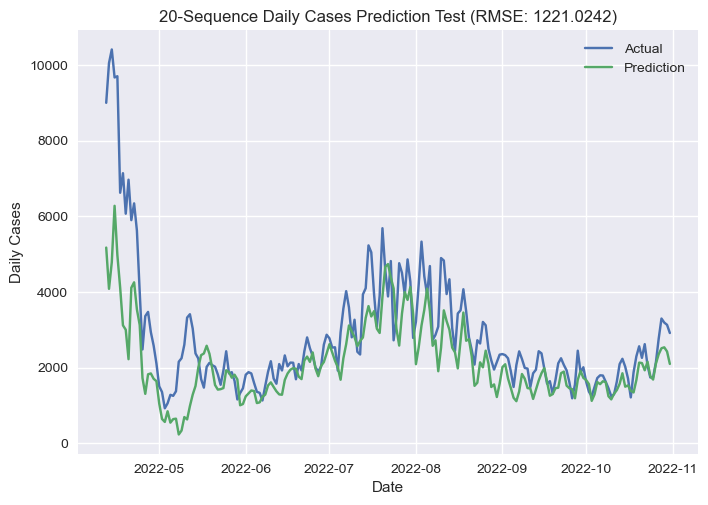

In [5]:
TRAIN_SPLIT = int(0.8 * len(df.index))
r_error = []
case_error = []
data = {'sequence_length' : []}

plt.style.use('seaborn')

for seq_length in range(1,21):
    test = df.loc[df.index >= df.index[TRAIN_SPLIT - seq_length],'reproduction_number'].tolist()
    x_test,y_test = set_sequence(seq_length,test)
    a = plot_test_r(df,x_test,model[seq_length],seq_length)
    b = plot_test_cases(df,x_test,model[seq_length],seq_length)
    r_error.append(a)
    case_error.append(b)
    data['sequence_length'].append(seq_length)

data['r_error'] = r_error
data['case_error'] = case_error

pd.DataFrame(data).to_csv(f'Model_{days_recovery}_Error.csv')

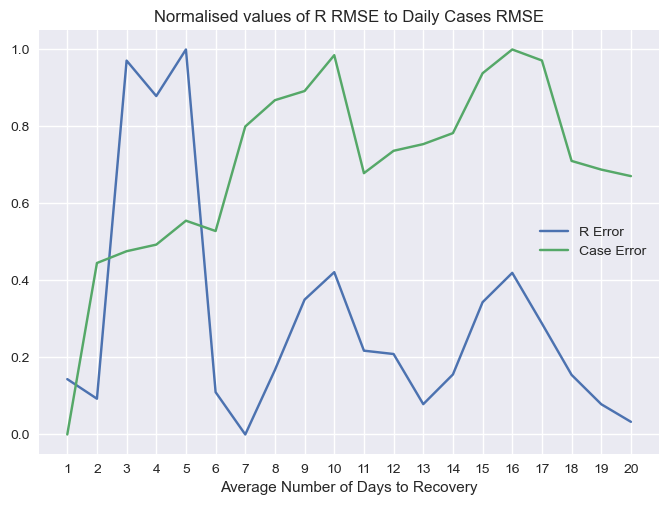

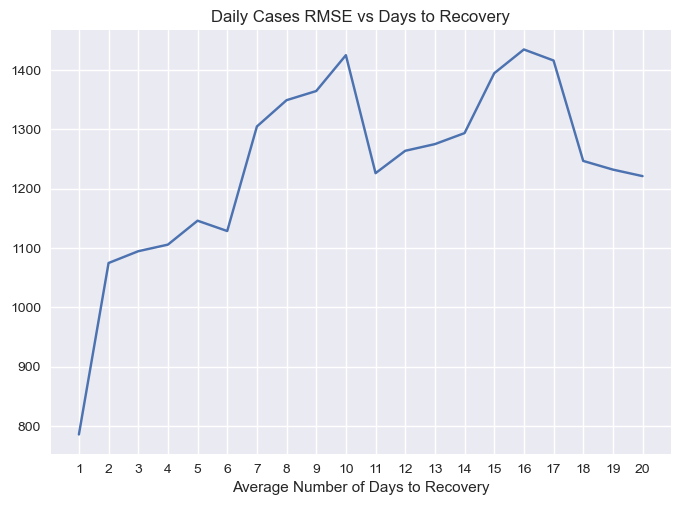

In [6]:
r_error = np.array(r_error)
r_error2 = np.insert(r_error,0,np.nan)
case_error  = np.array(case_error)
case_error2 = np.insert(case_error,0,np.nan)

plt.style.use('seaborn')
plt.figure()
plt.plot((r_error2 - r_error.min()) / (r_error.max() - r_error.min()))
plt.plot((case_error2 - case_error.min()) / (case_error.max() - case_error.min()))
plt.legend(['R Error','Case Error'])
plt.title('Normalised values of R RMSE to Daily Cases RMSE')
plt.xlabel('Average Number of Days to Recovery')
plt.xticks(range(1,21))
plt.show()

plt.figure()
plt.plot(case_error2)
plt.title('Daily Cases RMSE vs Days to Recovery')
plt.xlabel('Average Number of Days to Recovery')
plt.xticks(range(1,21))
plt.show()

In [7]:
a = np.array([1,2,3])
print(a)

a = np.insert(a,0,3)

a

[1 2 3]


array([3, 1, 2, 3])